## Part 1: 
Load data, clean, and save aggregate data

In [1]:
import pandas as pd 
import os
import numpy as np
from data_cleaning import change_columns_types
from data_loading import aggregate_data
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#immport necessary libraries and filter warnings
import warnings


from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer
from utility_db_25 import mark_columns, TrainML, build_catboost, optuna_call, test_ML, build_transformer, get_momentum_cols, create_momentum_index, get_final_features, get_motion_cols, motion_complexity_score
from team_logos import graph_run_pass, get_logo_df, load_previous_year_passruns
warnings.filterwarnings("ignore")

In [2]:
#graph_run_pass()

In [3]:
root_dir = os.getcwd()

load_saved_data = True # if you change this to true you can load presaved data

if not load_saved_data: 
    games_fname= os.path.join(root_dir, "data/games.csv")
    plays_fname = os.path.join(root_dir,  "data/plays.csv")
    players_fname = os.path.join(root_dir,  "data/players.csv")
    player_plays_fname = os.path.join(root_dir,  "data/player_play.csv")
    c21_fname = os.path.join(root_dir, 'data_21/cov_21.csv')
    pr21_fname = os.path.join(root_dir, 'data_21/team_pr_21.csv')
    xp_fname = os.path.join(root_dir, "data/team_xpass_ratios.csv")
    pr_fname = os.path.join(root_dir, "data/team_pass_rates.csv")
    cf_fname = os.path.join(root_dir, "data/coverages_faced.csv")
    cu_fname = os.path.join(root_dir, 'data/coverages_used.csv')
    inj_fname = os.path.join(root_dir, 'data/snaps_lost_injury.csv')
    qbr_fname = os.path.join(root_dir, 'data/qbr_data.csv')
    tracking_fname_list_train = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,9)] #weeks 1-8 are training data
    tracking_fname_list_test = [os.path.join(root_dir,  "data/tracking_week_9.csv")] #week 9 is test data
    train_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_train, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname, qbr_fname,'train')
    train_data.to_csv(os.path.join(root_dir, "data/train_data.csv"), index=False)
    test_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_test, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname, qbr_fname, 'test')
    test_data.to_csv(os.path.join(root_dir, "data/test_data.csv"), index=False)
else:
    train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

train colums:  440
test colums:  357


In [4]:
include_columns=[x for x in test_data.columns if '_def' not in x]+['pass_rate_def']
train_data=train_data[include_columns]
test_data = test_data[include_columns]


In [5]:

momentum_cols=get_momentum_cols(train_data.columns)

train_data=create_momentum_index(train_data, momentum_cols)
test_data=create_momentum_index(test_data, momentum_cols)
motion_cols=get_motion_cols(train_data.columns)
train_data=motion_complexity_score(train_data, motion_cols)
test_data=motion_complexity_score(test_data, motion_cols)




## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment.

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [6]:

for col in train_data.columns: 
    if round((train_data[col].isna().sum() /len(train_data)*100), 2)>75:
        train_data.drop(columns=col, inplace=True)
    elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>0:
        print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
    else: 
        print(col)

gameId
playId
quarter
down
yardsToGo
score_differential
time_remaining 0.81 % missing
playNullifiedByPenalty
preSnapHomeTeamWinProbability
pass_rush_ratio 2.84 % missing
Rain
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
preSnapVisitorTeamWinProbability
absoluteYardlineNumber
pass
s|max|C_1
s|max|C_2
s|max|FB_1
s|max|G_1
s|max|G_2
s|max|G_3
s|max|ILB_1
s|max|QB_1
s|max|RB_1
s|max|RB_2
s|max|TE_1
s|max|TE_2
s|max|TE_3
s|max|T_1
s|max|T_2
s|max|T_3
s|max|T_4
s|max|WR_1
s|max|WR_2
s|max|WR_3
s|max|WR_4
s|max|WR_5
a|max|C_1
a|max|C_2
a|max|FB_1
a|max|G_1
a|max|G_2
a|max|G_3
a|max|ILB_1
a|max|QB_1
a|max|RB_1
a|max|RB_2
a|max|TE_1
a|max|TE_2
a|max|TE_3
a|max|T_1
a|max|T_2
a|max|T_3
a|max|T_4
a|max|WR_1
a|max|WR_2
a|max|WR_3
a|max|WR_4
a|max|WR_5
o_standard|mean|C_1
o_standard|mean|C_2
o_standard|mean|FB_1
o_standard|mean|G_1
o_standard|mean|G_2
o_standard|mean|G_3
o_standard|mean|ILB_1
o_standard|mean|QB_1
o_standard|mean|RB_1
o_standard|mean|RB_2
o_standard|mean|TE_1
o_sta

In [7]:
len(train_data.columns)

304

In [8]:
train_data=change_columns_types(train_data)
test_data=change_columns_types(test_data)

In [9]:
final_features=get_final_features(train_data,threshold=.6,trim_rows=0)

In [10]:
#final_features.remove('xpass_situational')

In [11]:
len(final_features)

28

In [13]:
final_features.remove('down')
final_features.remove('yardsToGo')

In [14]:
numeric_columns, cat_columns = mark_columns(df=train_data,features=final_features, nc=None,cc = None)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

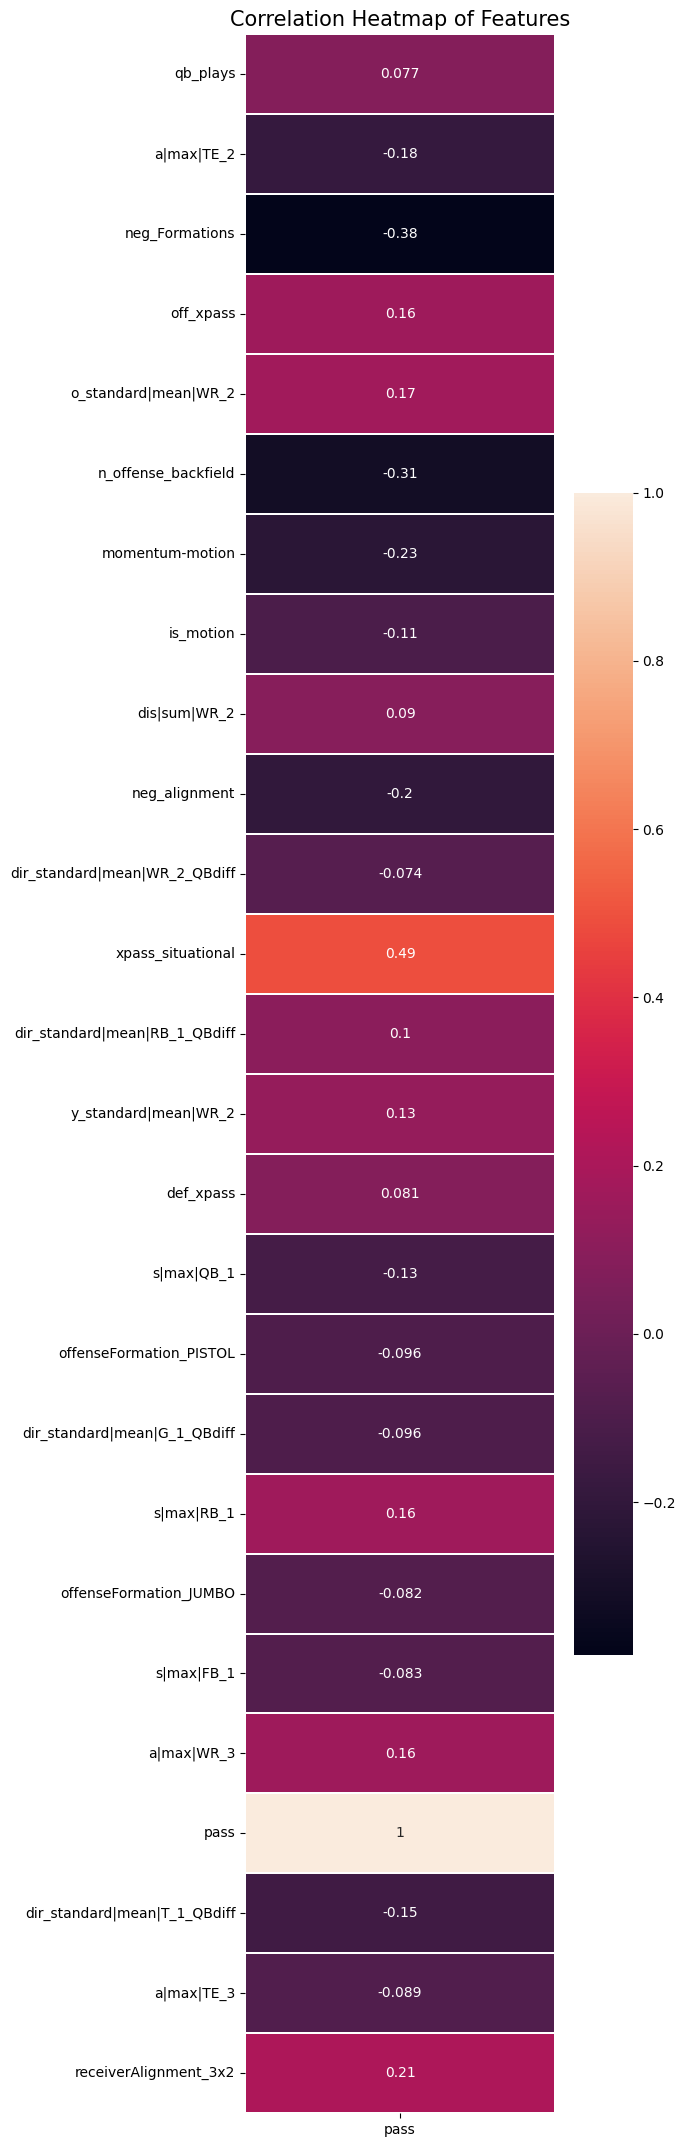

In [15]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,27))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(train_data[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [16]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer

# Fit and transform the data
#merged_pivot[numeric_columns] = imputer.fit_transform(merged_pivot[numeric_columns])
imputer = SimpleImputer(missing_values = np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [17]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=train_data[final_features].drop(columns='pass')

y=train_data['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 21.25it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


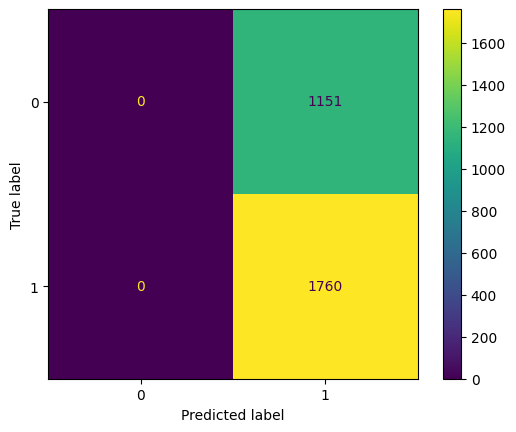

In [18]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y, n_splits,SEED)

Training Folds: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]

Mean Train AUC --> 0.8714
Mean Validation AUC ---> 0.7764
Mean Train Accuracy --> 0.8792
Mean Validation Accuracy ---> 0.7889


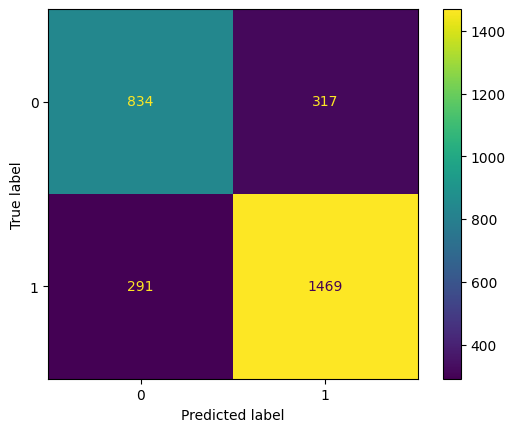

In [19]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X,y)
TrainML(pipeline,X, y,n_splits,SEED)

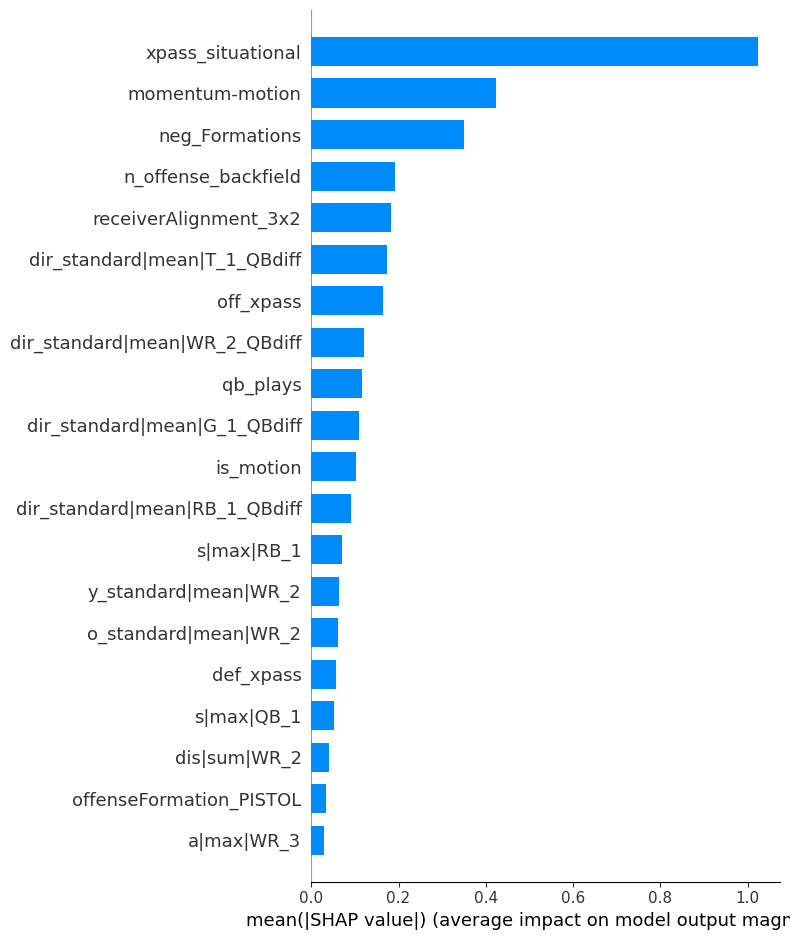

In [20]:
import shap 

shap_values = shap.TreeExplainer(lgb).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

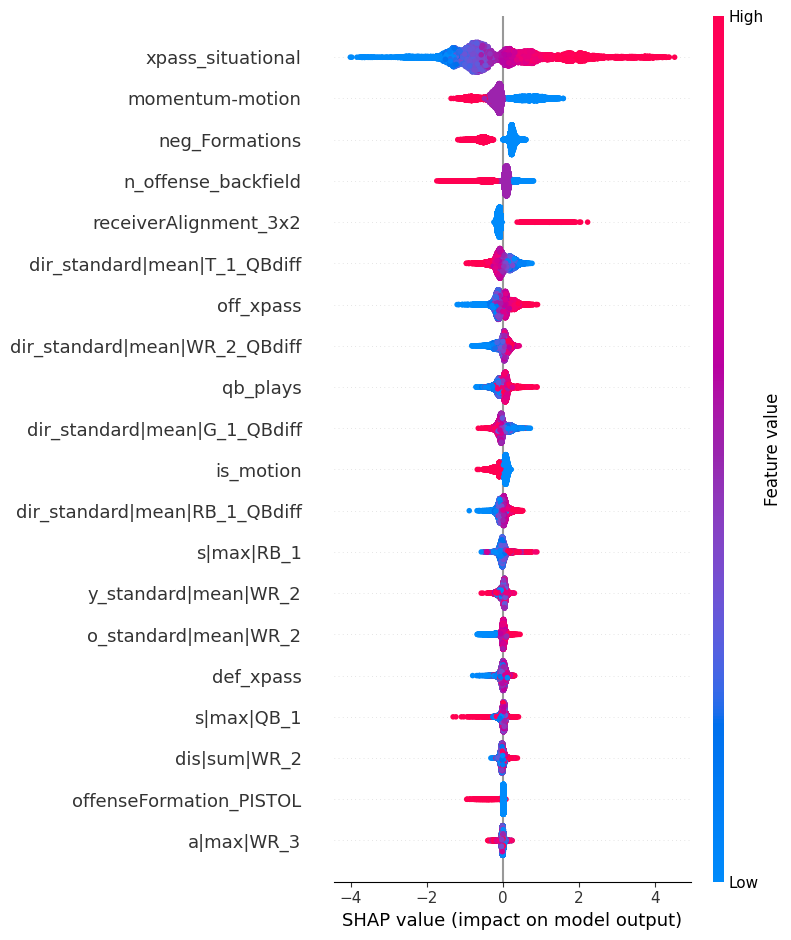

In [21]:
shap.summary_plot(shap_values, X)

In [22]:
final_features.remove('pass')

<Axes: >

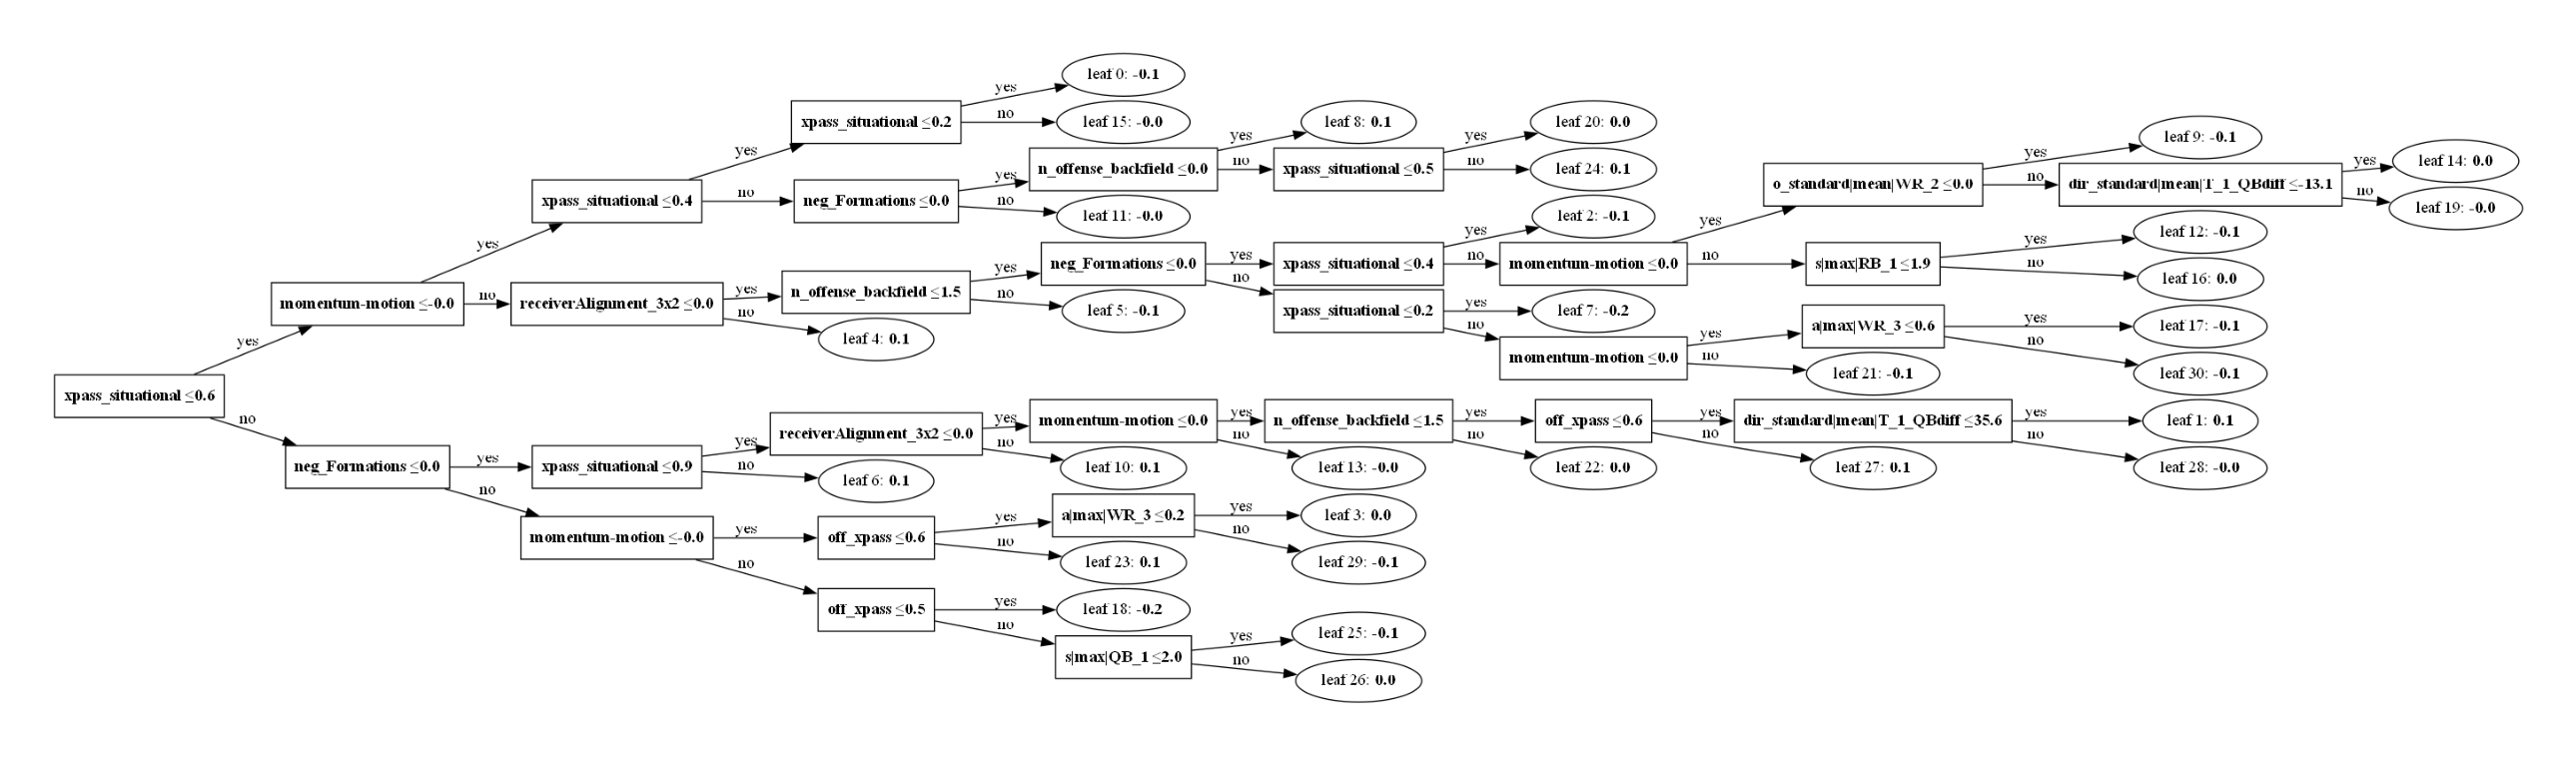

In [23]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline
#need graphviz for this part and to add to path https://graphviz.org/download/

# For explicitly displaying widgets
from IPython.display import display
import lightgbm


lightgbm.plot_tree(lgb, tree_index=3,dpi=500,precision=1)
#lightgbm.plot_tree(lgb, tree_index=1,dpi=300, ax=ax[1])

In [24]:
final_numeric_columns, final_cat_columns = mark_columns(df=train_data,features=final_features, nc=numeric_columns,cc = cat_columns)

In [25]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [26]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
#best_features=['xpass_situational', 'presnap_motion_complexity', 'presnap_momentum', 'receiverAlignment_3x2', 'offenseFormation_SINGLEBACK']

X=train_data[final_features]

y=train_data['pass']
# Define the helper function so that it can be reused

#cat_params = optuna_call(transformer,X,y,SKF,n_trials=20)

In [27]:
transformer_impute = build_transformer(imputer,numeric_columns,kind='imputer')
transformer_scale = build_transformer(imputer,numeric_columns,kind='scaler')

In [28]:
from sklearn.model_selection import GridSearchCV

# Initialize an empty dictionary to store the best hyperparameters and their values
best_hyperparameters = {}
best_values = {}
 
# Initialize the LightGBM classifier
lgb_classifier = lightgbm.LGBMClassifier(force_col_wise=True, deterministic=True, random_state=42)

# Define a range of values for the hyperparameters to search through
param_grid = {
    'boosting_type' : ['gbdt', 'dart'],
    'num_leaves': [25,  50],
    'learning_rate': [.08, .09, 0.1],
    'depth': [6,7,8,9,10],
    'n_estimators': [75, 100, 125],
    #'is_unbalance': [True],
    'random_state': [42],
    "deterministic": [True]
}
 
# Initialize GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=5)
 

# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X,y)
 
# Get the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())


In [29]:
best_params

{'boosting_type': 'gbdt',
 'depth': 6,
 'deterministic': True,
 'learning_rate': 0.08,
 'n_estimators': 75,
 'num_leaves': 25,
 'random_state': 42}

In [30]:

''' 
best_params = {'boosting_type': 'dart',
 'deterministic': True,
 #'is_unbalance': True,
 'learning_rate': 0.15,
 'n_estimators': 100,
 'num_leaves': 50,
 'random_state': 42}
 '''

" \nbest_params = {'boosting_type': 'dart',\n 'deterministic': True,\n #'is_unbalance': True,\n 'learning_rate': 0.15,\n 'n_estimators': 100,\n 'num_leaves': 50,\n 'random_state': 42}\n "

In [31]:
train_data['pass'].value_counts()

1    8801
0    5755
Name: pass, dtype: int64

In [32]:
# Train a LightGBM model with the best hyperparameters
best_model = lightgbm.LGBMClassifier(**best_params)
best_model.fit(X,y)

LGBMClassifier(depth=6, deterministic=True, learning_rate=0.08, n_estimators=75,
               num_leaves=25, random_state=42)

In [33]:
y_pred = best_model.predict(test_data[final_features])
y_test = test_data['pass']

In [34]:
accuracy_score(y_test, y_pred)

0.8254901960784313

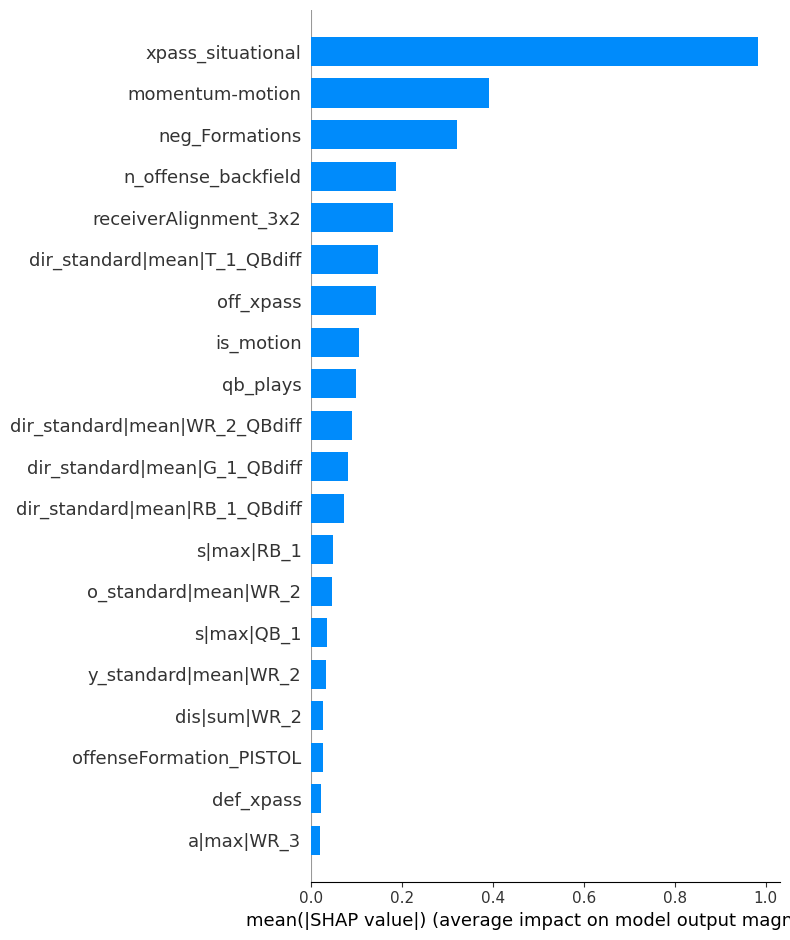

In [35]:
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
feature_names = final_features


lgbm_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(lgbm_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)


In [36]:
shap_importance.head(10).set_index('col_name').T.columns

Index(['xpass_situational', 'momentum-motion', 'neg_Formations',
       'n_offense_backfield', 'receiverAlignment_3x2',
       'dir_standard|mean|T_1_QBdiff', 'off_xpass', 'is_motion', 'qb_plays',
       'dir_standard|mean|WR_2_QBdiff'],
      dtype='object', name='col_name')

AUC --> 0.8183445586671393
Accuracy --> 0.8254901960784313


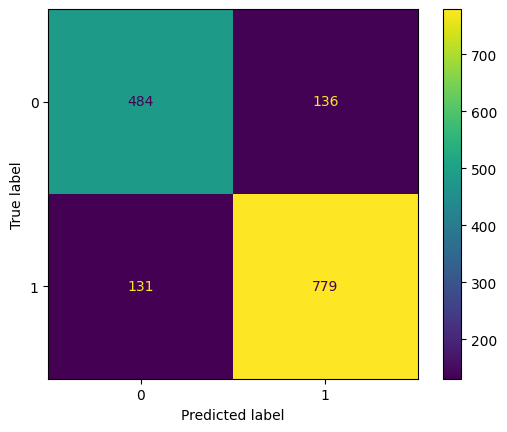

In [37]:
test_ML(test_data, best_model,final_features,transformer_impute,transformer_scale)

In [38]:

# Obtain gain feature importance
gain_importance = best_model.feature_importances_

# Display feature importance with feature names
feature_names = X[final_features]
gain_importance_df = pd.DataFrame({'Feature': final_features, 'Gain': gain_importance})
gain_importance_df.sort_values(by='Gain', ascending=False).head(20).set_index('Feature').T.columns

Index(['xpass_situational', 'qb_plays', 'dir_standard|mean|T_1_QBdiff',
       'off_xpass', 'momentum-motion', 's|max|RB_1',
       'dir_standard|mean|WR_2_QBdiff', 's|max|QB_1',
       'dir_standard|mean|RB_1_QBdiff', 'dir_standard|mean|G_1_QBdiff',
       'n_offense_backfield', 'y_standard|mean|WR_2', 'def_xpass',
       'o_standard|mean|WR_2', 'dis|sum|WR_2', 'receiverAlignment_3x2',
       'neg_Formations', 'is_motion', 'a|max|WR_3', 'offenseFormation_PISTOL'],
      dtype='object', name='Feature')

In [39]:
len(final_features)

25